# Свёрточные сети. Pytorch. 


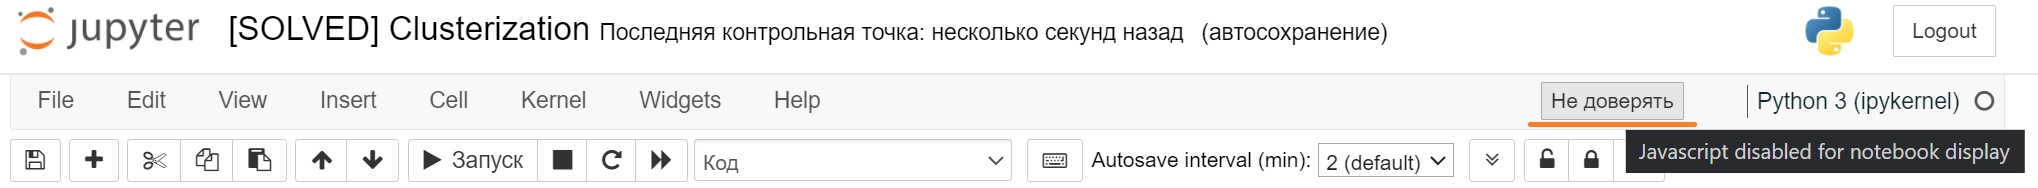

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import numpy as np

import torch

In [ ]:

class DatasetExample(torch.utils.data.Dataset):
    def __init__(self):
        super().__init__()
        
    def __getitem__(self, idx):
        '''
        Возвращает элемент датасета по его индексу
        :param int idx: Номер элемента в датасете
        :returns: Объект из выборки с порядковым номером idx
        '''
        ...
        
    def __len__(self):
        '''
        Опциональный метод, возвращает число элементов в датасете
        '''
        ...
```

Базовая работа с изображениями в **Pytorch** выделена в отдельный модуль `torchvision`. Эта библиотека позволяет:
* Загружать и работать с популярными датасетами компьютерного зрения
* Применять преобразования к изображениям в `PIL`, `numpy.ndarray` и `torch.Tensor` форматах
* Использовать специфичные для CV блоки и функции потерь
* Использовать готовые архитектуры CV моделей (включая предобученные модели)

Все датасеты в библиотеке `torchvision` наследуются от `torch.utils.data.Dataset`. Также, почти все датасеты имеют аргументы конструктора класса `transforms` и `target_transform`, которые определяют трансформации, применяемые ко входам сети (обычно к изображениям) и к таргетам (обычно к меткам классов) соответственно. Основные сценарии использования трансформаций включают в себя:
* Преобразование изображений из одного формата в другой. Например, обычно датасеты хранят и возвращают изображения в `PIL` формате, тогда как в нейросеть необходимо передавать изображения в виде `torch.Tensor`
* Нормализация и аугментация изображений
* Нормализация меток классов, то есть перевод их и строкового представления в численное

В библиотеке `torchvision` содержится большой набор [готовых трансформаций](https://pytorch.org/vision/stable/transforms.html).

Для работы с датасетом `CIFAR10` нам понадобится следующие из них:
* `torchvision.transforms.ToTensor` — преобразование `PIL` изображения в `torch.Tensor`
* `torchvision.transforms.Normalize` — нормализация изображения в формате `torch.Tensor`
* `torchvision.transforms.Compose` — класс, позволяющий объединять несколько последовательных трансформаций в одну

In [3]:
import torchvision

Загрузим датасет `CIFAR10` и посмотрим на его содержимое: 

In [4]:
# Обратите внимание на аргументы функции: 
#   train отвечает за то, какой сплит нужно использовать, то есть обучающую или тестовую выборку
#   download отвечает за загрузку датасета из интернета
ds_train_no_transform = torchvision.datasets.CIFAR10(
    root='./', train=True, transform=None, download=True
)

Files already downloaded and verified


Описание датасета:
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./
    Split: Train

Объект датасета — PIL изображение и метка: (<PIL.Image.Image image mode=RGB size=32x32 at 0x7F4F7166F940>, 6)



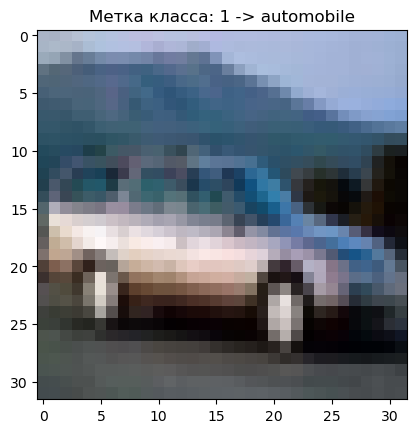

In [5]:
print(f'Описание датасета:\n{ds_train_no_transform}\n')
print(f'Объект датасета — PIL изображение и метка: {ds_train_no_transform[0]}\n')

image, label = ds_train_no_transform[4]

plt.imshow(image)

plt.title(f'Метка класса: {label} -> {ds_train_no_transform.classes[label]}')
plt.show()

Создадим `transform` для изображения, которое преобразует его из `PIL` формата в `torch.Tensor`, а затем нормализует:

In [6]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    # Используем среднее и стандартное отклонение, посчитанные для датасета CIFAR10
    # https://github.com/kuangliu/pytorch-cifar/issues/16
    torchvision.transforms.Normalize(
        mean=(0.4914, 0.4822, 0.4465), 
        std=(0.2023, 0.1994, 0.2010)
    )
])

Применим трансформацию к изображению:

Тип изображения до трансформации: <class 'PIL.Image.Image'>. Размер: (32, 32). Тип изображения: RGB
Тип изображения после трансформации: <class 'torch.Tensor'>. Размер: torch.Size([3, 32, 32])


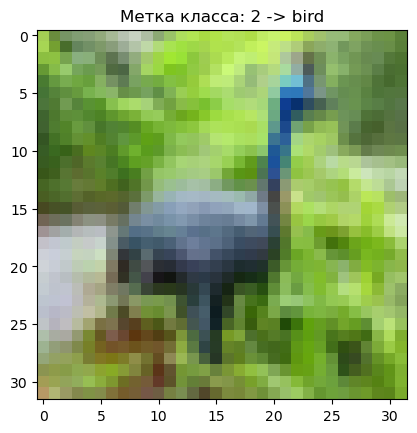

In [7]:
image, label = ds_train_no_transform[6]
print(f'Тип изображения до трансформации: {type(image)}. Размер: {image.size}. Тип изображения: {image.mode}')

image_tensor = transform(image)
print(f'Тип изображения после трансформации: {type(image_tensor)}. Размер: {image_tensor.shape}')

plt.imshow(image)

plt.title(f'Метка класса: {label} -> {ds_train_no_transform.classes[label]}')
plt.show()

Создадим датасеты с обучающим и тестовым сплитом датасета `CIFAR10`. Не забудьте передать функцию для трансформации.

In [8]:

ds_train = torchvision.datasets.CIFAR10(
    root='./', train=True, transform=transform, download=True
)
ds_test = torchvision.datasets.CIFAR10(
    root='./', train=False, transform=transform, download=True
)

Files already downloaded and verified
Files already downloaded and verified


In [9]:
ds_train, ds_test

(Dataset CIFAR10
     Number of datapoints: 50000
     Root location: ./
     Split: Train
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
            ),
 Dataset CIFAR10
     Number of datapoints: 10000
     Root location: ./
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
            ))

Для удобства сразу же определим обратное преобразование, которое из тензора делает PIL изображение, которое можно корректно отобразить:

In [10]:
tmean, tstd = transform.transforms[1].mean, transform.transforms[1].std
tmean, tstd = np.array(tmean), np.array(tstd)

inverse_transform = transform = torchvision.transforms.Compose([
    torchvision.transforms.Normalize(
        mean=-tmean / tstd, 
        std=1.0 / tstd
    ),
    torchvision.transforms.ToPILImage()
])

Посмотрим на несколько изображений из обучающей и тестовой выборок:

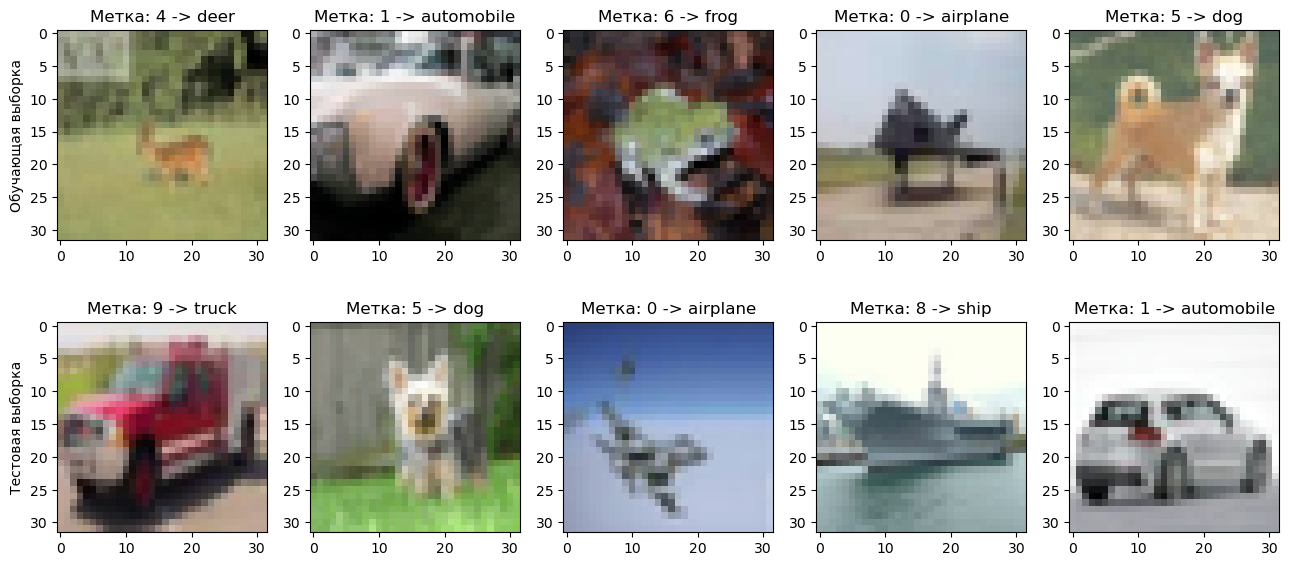

In [11]:
fig, axes = plt.subplots(2, 5, figsize=(13, 6))

for idx, ds in enumerate((ds_train, ds_test)):
    for jdx, kdx in enumerate(np.random.randint(0, len(ds), size=5)):
        image, label = ds[kdx]
        axes[idx, jdx].imshow(inverse_transform(image))
        axes[idx, jdx].set_title(f'Метка: {label} -> {ds.classes[label]}')
        
axes[0, 0].set_ylabel('Обучающая выборка')
axes[1, 0].set_ylabel('Тестовая выборка')
        
fig.tight_layout()
plt.show()

Используем класс, который преобразует датасет в генератор батчей `torch.utils.data.DataLoader`. Данная обёртка позволяет объединять объекты в один батч, то есть объединять соответствующие тензоры в каждом объекте (например, изображения и соответствующие метки).

Основные параметры даталоадера:
- `batch_size` — размер подвыборки, семплируемый при каждом обращении к инстансту
- `shuffle` — перемешивать выборку или нет
- `num_workers` — ключевой параметр, который определяет производительность генератора батчей. Опишем влияние этого параметра подробнее. В процессе генерации очередного батча даталоадер должен выполнить несколько медленных процедур: запрос объектов из соответствующего датасета, что часто включает в себя чтение из жёсткого диска (так как большие датасеты не помещаются в оперативную память), применение трансформаций ко всем изображениям и конкатенация отдельных объектов в один тензор. Часто оказывается так, что вычисление прямого прохода по сети происходит быстрее, чем генерируется очередной батч, что приводит к существенно неэффективной программе. В таком случае, необходимо увеличить число параллельных процессов, каждый из которых генерирует очередной батч данных. На практике, выбор правильного числа воркеров может давать кратный прирост в скорости (обычно, перебор начинают с $3-4$ воркеров) 

Создайте даталоадеры для обучающей и тестовой выборок CIFAR10. Учтите, что обучающая выборка должна перемешиваться при каждом проходе по выборке, а тестовая выборка — нет.

In [12]:
batch_size = 128


dl_train = torch.utils.data.DataLoader(dataset=ds_train, batch_size=batch_size, shuffle=True, num_workers=2)
dl_test = torch.utils.data.DataLoader(dataset=ds_test, batch_size=batch_size, shuffle=True, num_workers=2)

Посмотрим на батч из даталоадера:

In [13]:
images, labels = next(iter(dl_train))
print(images.shape, labels.shape)

torch.Size([128, 3, 32, 32]) torch.Size([128])


Реализуем свёрточную VGG-подобную сеть. Сеть будет состоять из трёх основных блоков:
1. Свёрточный feature extractor
    * Эта последовательность слоёв принимает на вход изображение с $3$ каналами
    * Последовательность слоёв задаётся конфигурационным списком `cfg`:
        - Число означает количество выходных каналов очередной свёртки. Используйте свёртки с ядром $3\times3$ и паддингом $1$
        - `"M"` означает слой Max Pooling. Каждый такой слой должен уменьшать пространственные размерности картинки в $2$ раза
2. Слой Adaptive Average Pooling
    - Используйте выходное пространственное разрешение $2\times2$
3. Полносвязная "голова"-классификатор с $2$ скрытыми слоями размерности $128$

* В качестве функции активации везде используйте `ReLU`
* В зависимости от флага `use_batchnorm` добавьте батчнорм после каждого свёрточного слоя
* Между полносвязными слоям добавьте слои `Dropout` со значением $p = \text{dropout\_p}$
* Используйте только готовые модули из `torch.nn`. Для объединения слоёв в блоки используйте `torch.nn.Sequential`

In [19]:
class ConvNet(torch.nn.Module):
    cfg = [32, "M", 64, 64, "M", 128, 128, "M"]
    
    def __init__(self, n_classes=10, use_batchnorm=False, dropout_p=0.0):
        '''
        :param int n_classes: Число выходных признаков
        :param bool use_batchnorm: Использовать ли батчнорм между свёрточными слоями
        :param float dropout_p: Вероятность обнуления активации слоем Dropout
        '''
        super().__init__()
        
        self.n_classes = n_classes
        
        
        self.features = self.make_conv_layers(self.cfg, use_batch_norm=use_batchnorm)
        self.avgpool = torch.nn.AdaptiveAvgPool2d((2, 2))
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(4 * 128, 128),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=dropout_p),
            torch.nn.Linear(128, 128),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=dropout_p),
            torch.nn.Linear(128, n_classes),
        )
    
    def make_conv_layers(self, config, use_batch_norm) -> torch.nn.Module:
        layers = []
        in_channels=3

        for value in config:
            if value == "M":
                layers += [
                    torch.nn.MaxPool2d(kernel_size=2)
                ]
            else:
                if use_batch_norm:
                    layers.extend([
                        torch.nn.Conv2d(in_channels=in_channels, out_channels=value,
                                        kernel_size=(3, 3), padding=1),
                        torch.nn.BatchNorm2d(value),
                        torch.nn.ReLU()
                    ])
                else:
                    layers.extend([
                        torch.nn.Conv2d(in_channels=in_channels, out_channels=value,
                                        kernel_size=(3, 3), padding=1),
                        torch.nn.ReLU()
                    ])
                in_channels = value

        return torch.nn.Sequential(*layers)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        output = self.features(x)
        output = self.avgpool(output)
        output = output.view((output.size()[0], -1))
        return self.classifier(output)

Проверим, что наша реализация сети проходит минимальные тесты:

In [15]:
device = torch.device('cuda', 0) # без переноса модели на карточку ядро крашится при прямом проходе, так что пробую с ней

In [20]:
assert sum(buffer.numel() for buffer in ConvNet(use_batchnorm=True).buffers()) == 837
assert sum(param.numel() for param in ConvNet(use_batchnorm=True).parameters()) == 362058
assert sum(param.numel() for param in ConvNet(use_batchnorm=False).parameters()) == 361226

sample_image = torch.randn([11, 3, 32, 32]).to(device)
sample_model = ConvNet(use_batchnorm=False, dropout_p=0.5).to(device)
assert torch.all(torch.ne(sample_model.train()(sample_image), sample_model.eval()(sample_image)))

assert list(ConvNet().to(device).features(sample_image).shape) == [11, 128, 4, 4]
assert list(ConvNet().to(device).avgpool(ConvNet().to(device).features(sample_image)).shape) == [11, 128, 2, 2]
assert list(ConvNet().to(device)(sample_image).shape) == [11, 10]

В качестве функции потерь будем использовать, так же как и в прошлом задании, кроссэнтропию, но в этот раз её готовую реализацию. В качестве оптимизатора возьмём базовый оптимизатор в машинном обучении — SGD:

In [17]:
conv_network = ConvNet()

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(conv_network.parameters(), lr=2e-2)

Определим устройство для вычислений и перенесём модель:

In [18]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda', 0)
    
print(type(device), device)

<class 'torch.device'> cuda:0


In [19]:
conv_network.to(device)

ConvNet(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(2, 2))
  (classifier): Sequential(
    (0): Linear(in_features=512, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=128, out_features=128, bi

Теперь осталось реализовать цикл обучения для нейронной сети. Так как в данном задании будет использоваться оптимизатор SGD, то необходимость в реализации шага оптимизации через функцию-замыкание отсутствует. Реализуйте шаг оптимизации любым удобным способом.

In [20]:
import tqdm.notebook as tqdm
from functools import partial

In [21]:
def training_loop(n_epochs, network, loss_fn, optimizer, dl_train, dl_test, device):
    '''
    :param int n_epochs: Число итераций оптимизации
    :param torch.nn.Module network: Нейронная сеть
    :param Callable loss_fn: Функция потерь
    :param torch.nn.Optimizer optimizer: Оптимизатор
    :param torch.utils.data.DataLoader dl_train: Даталоадер для обучающей выборки
    :param torch.utils.data.DataLoader dl_test: Даталоадер для тестовой выборки
    :param torch.Device device: Устройство на котором будут происходить вычисления
    :returns: Списки значений функции потерь и точности на обучающей и тестовой выборках после каждой итерации
    '''
    train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []
    pbar = tqdm.tqdm(range(n_epochs), total=n_epochs, leave=False)
    for epoch in pbar:
        # Переводим сеть в режим обучения
        network.train()

        # Итерация обучения сети
        for images, labels in tqdm.tqdm(dl_train, total=len(dl_train), leave=False):
            # Реализуйте шаг оптимизации. Использовать функцию-замыкание для передачи в оптимизатор не обязательно
            # Можете вынести подсчёт градиентов из функции в сам цикл
            images = images.to(device)
            labels = labels.to(device)
                
            def closure():
                '''
                Функция-замыкания для подсчёта градиентов функции потерь по обучающей выборке:
                    1. Отчистка текущих градиентов
                    2. Выполнение прямого прохода по сети в вычисление функции потерь
                    3. Вычисление градиентов функции потерь
                    
                Для передачи аргументов в функцию-замыкание можно использовать функцию partial
                :returns: Значение функции потерь
                '''
                optimizer.zero_grad()
                output = network(images)
                loss = loss_fn(output, labels)
                loss.backward()
                return loss
        
            # Шаг оптимизации
            optimizer.step(closure)
        
        # Оцениваем качество модели каждые 3 итерации
        if epoch % 3 == 0 or epoch == n_epochs - 1:
            # Переводим сеть в инференс режим
            network.eval()

            # При тестировании сети нет необходимости считать градиенты, поэтому можно отключить автоматическое дифференцирование
            #   для ускорения операций
            with torch.no_grad():
                train_loss = 0
                train_acc = 0
                n_train_images = 0
                # Вычисление качества и функции потерь на обучающей выборке
                for images, labels in tqdm.tqdm(dl_train, total=len(dl_train), leave=False):
                    images = images.to(device)
                    labels = labels.to(device)

                    output_train = network(images)
                    train_loss += float(loss_fn(output_train, labels).cpu())

                    train_acc += int((output_train.argmax(dim=1) == labels).sum())
                    n_train_images += len(labels)

                train_losses.append(train_loss)
                train_accuracies.append(train_acc / n_train_images)
                
                test_loss = 0
                test_acc = 0
                n_test_images = 0
                # Вычисление качества и функции потерь на тестовой выборке
                for images, labels in tqdm.tqdm(dl_test, total=len(dl_train), leave=False):
                    images = images.to(device)
                    labels = labels.to(device)

                    output_test = network(images)
                    test_loss += float(loss_fn(output_test, labels).cpu())

                    test_acc += int((output_test.argmax(dim=1) == labels).sum())
                    n_test_images += len(labels)

                test_losses.append(test_loss)
                test_accuracies.append(test_acc / n_test_images)
            
            pbar.set_description(
                'Loss (Train/Test): {0:.3f}/{1:.3f}. Accuracy, % (Train/Test): {2:.2f}/{3:.2f}\n'.format(
                    train_losses[-1], test_losses[-1], train_accuracies[-1], test_accuracies[-1]
                )
            )
            
    return train_losses, test_losses, train_accuracies, test_accuracies

Наконец, всё готово к обучению модели:

In [22]:
n_epochs = 100
train_losses, test_losses, train_accs, test_accs = training_loop(
    n_epochs=n_epochs, network=conv_network, loss_fn=loss_fn, 
    optimizer=optimizer, dl_train=dl_train, dl_test=dl_test, device=device
)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

 Посторим график качества на обучении и на тесте: 

In [23]:
points = [i for i in range(0, n_epochs) if i %3 == 0 or i == n_epochs - 1]

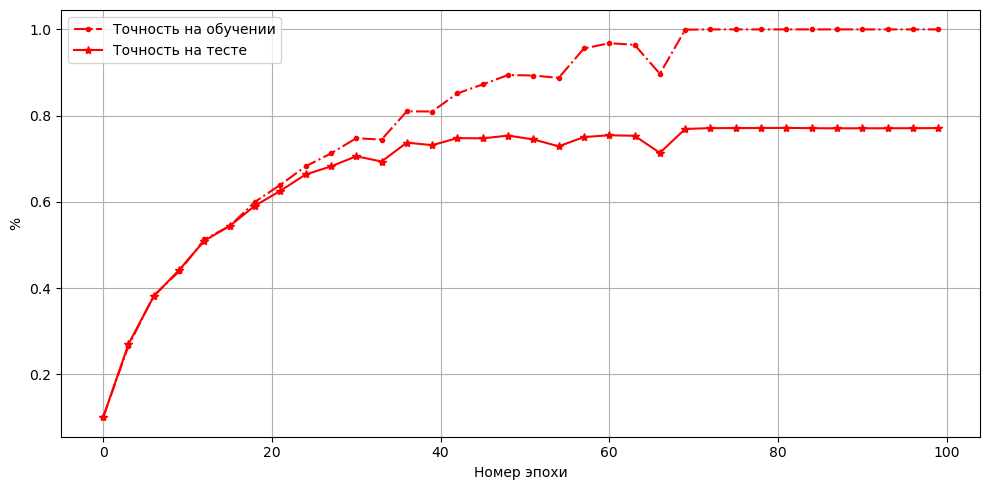

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(points, train_accs, label="Точность на обучении", color='red', marker='.', linestyle='-.')
ax.plot(points, test_accs, label="Точность на тесте", color='red', marker='*')

ax.set_xlabel("Номер эпохи")
ax.set_ylabel("$\%$")

ax.grid(True)
ax.legend()

fig.tight_layout()
plt.show()

 Теперь, для сравнения обучите модели с батчнормом, дропаутом (используйте $p=0.5$) и с тем и с другим. Не забудьте сохранить все метрики, чтобы затем сравнить на графике все $4$ рассмотренные модели:

In [25]:
conv_network_dp = ConvNet(dropout_p=0.5).to(device)
optimizer_dp = torch.optim.SGD(conv_network_dp.parameters(), lr=2e-2)
train_losses_dp, test_losses_dp, train_accs_dp, test_accs_dp = training_loop(
    n_epochs=n_epochs, network=conv_network_dp, loss_fn=torch.nn.CrossEntropyLoss(),
    optimizer=optimizer_dp, dl_train=dl_train, dl_test=dl_test, device=device
)

conv_network_bn = ConvNet(use_batchnorm=True).to(device)
optimizer_bn = torch.optim.SGD(conv_network_bn.parameters(), lr=2e-2)
train_losses_bn, test_losses_bn, train_accs_bn, test_accs_bn = training_loop(
    n_epochs=n_epochs, network=conv_network_bn, loss_fn=torch.nn.CrossEntropyLoss(),
    optimizer=optimizer_bn, dl_train=dl_train, dl_test=dl_test, device=device
)

conv_network_bn_dp = ConvNet(use_batchnorm=True, dropout_p=0.5).to(device)
optimizer_bn_dp = torch.optim.SGD(conv_network_bn_dp.parameters(), lr=2e-2)
train_losses_bn_dp, test_losses_bn_dp, train_accs_bn_dp, test_accs_bn_dp = training_loop(
    n_epochs=n_epochs, network=conv_network_bn_dp, loss_fn=torch.nn.CrossEntropyLoss(),
    optimizer=optimizer_bn_dp, dl_train=dl_train, dl_test=dl_test, device=device
)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

In [ ]:
points = [i for i in range(0, n_epochs) if i %3 == 0 or i == n_epochs - 1]

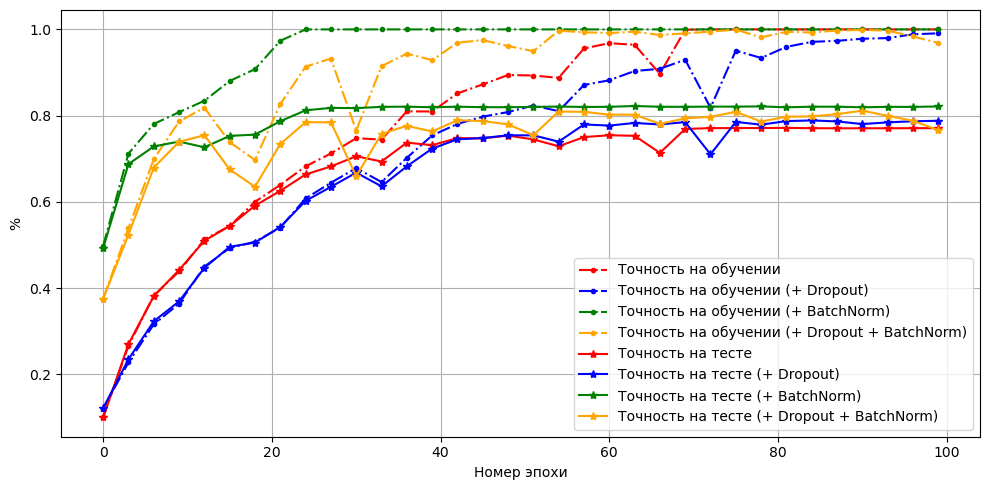

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(points, train_accs, label="Точность на обучении", color='red', marker='.', linestyle='-.')
ax.plot(points, train_accs_dp, label="Точность на обучении (+ Dropout)", color='blue', marker='.', linestyle='-.')
ax.plot(points, train_accs_bn, label="Точность на обучении (+ BatchNorm)", color='green', marker='.', linestyle='-.')
ax.plot(points, train_accs_bn_dp, label="Точность на обучении (+ Dropout + BatchNorm)", color='orange', marker='.', linestyle='-.')

ax.plot(points, test_accs, label="Точность на тесте", color='red', marker='*')
ax.plot(points, test_accs_dp, label="Точность на тесте (+ Dropout)", color='blue', marker='*')
ax.plot(points, test_accs_bn, label="Точность на тесте (+ BatchNorm)", color='green', marker='*')
ax.plot(points, test_accs_bn_dp, label="Точность на тесте (+ Dropout + BatchNorm)", color='orange', marker='*')

ax.set_xlabel("Номер эпохи")
ax.set_ylabel("$\%$")

ax.grid(True)
ax.legend()

fig.tight_layout()
plt.show()

После того, как модель обучена, её веса необходимо сохранить. В **Pytorch** предусмотрен отдельный интерфейс для сохранения и последующей загрузки весов модели. Во-первых, информацию, необходимую для восстановления состояния модели, можно получить через метод `state_dict` класса `torch.nn.Module`. По умолчанию этот метод возвращает словарь со всеми **ненулевыми параметрами и буферами модели**. Обратный метод `load_state_dict` позволяет установить значения параметров и буферов из словаря. Во-вторых, для сохранения весов на диск и последующей их загрузки с диска используют методы `torch.save` и `torch.load`.

Рассмотрим эту процедуру на примере:

In [31]:
state_dict = conv_network_bn_dp.state_dict()
print(state_dict)

OrderedDict([('features.0.weight', tensor([[[[-3.1275e-01,  1.4830e-01,  1.5628e-01],
          [-4.2633e-01,  2.9069e-01,  5.7289e-02],
          [-2.2423e-01,  7.2788e-02,  1.9813e-01]],

         [[-3.1824e-01,  2.4352e-01, -4.4224e-02],
          [-2.1654e-01,  4.3564e-01, -4.1253e-02],
          [-1.4299e-01,  3.7691e-01, -2.3508e-01]],

         [[-2.6504e-01,  3.9905e-01,  1.8056e-02],
          [-4.1183e-01,  3.2095e-01, -5.2994e-02],
          [-3.6541e-01,  3.4272e-01, -7.0915e-04]]],


        [[[-2.1107e-01,  1.0614e-01,  1.0829e-01],
          [-6.2830e-02, -1.8223e-03,  6.3773e-02],
          [-1.0636e-02,  7.5554e-02,  9.3012e-02]],

         [[-6.6655e-02, -1.7236e-01,  2.8588e-02],
          [-1.2484e-01,  7.6459e-02,  1.6647e-01],
          [-9.5694e-02, -1.1554e-01,  6.2635e-02]],

         [[ 1.2387e-01,  1.9705e-01,  1.6285e-01],
          [-1.2745e-01,  8.3454e-02, -5.3533e-02],
          [ 1.3484e-02,  1.6360e-01,  1.1930e-01]]],


        [[[-1.8682e-01, -4.1981

In [32]:
torch.save(state_dict, 'conv_weights.pt')

In [22]:
import os
os.listdir()

['Homework_1.2._Convolutional_Networks.ipynb',
 'conv_weights.pt',
 'conv_weights_pretrained.pt',
 'cifar-10-python.tar.gz',
 'cifar-10-batches-py',
 '.ipynb_checkpoints']

Заметим, что при работе в **Google Colab**, сохранённые файлы будут существовать лишь пока работает соответствующий Jupyter Notebook. При его перезагрузке, эти данные будут отчищены. Чтобы решить данную проблему, можно выполнить сохранение весов на Ваш личный **Google Drive**, предварительно примонтировав его следующей командой:

```python
from google.colab import drive
drive.mount('/content/drive')
```

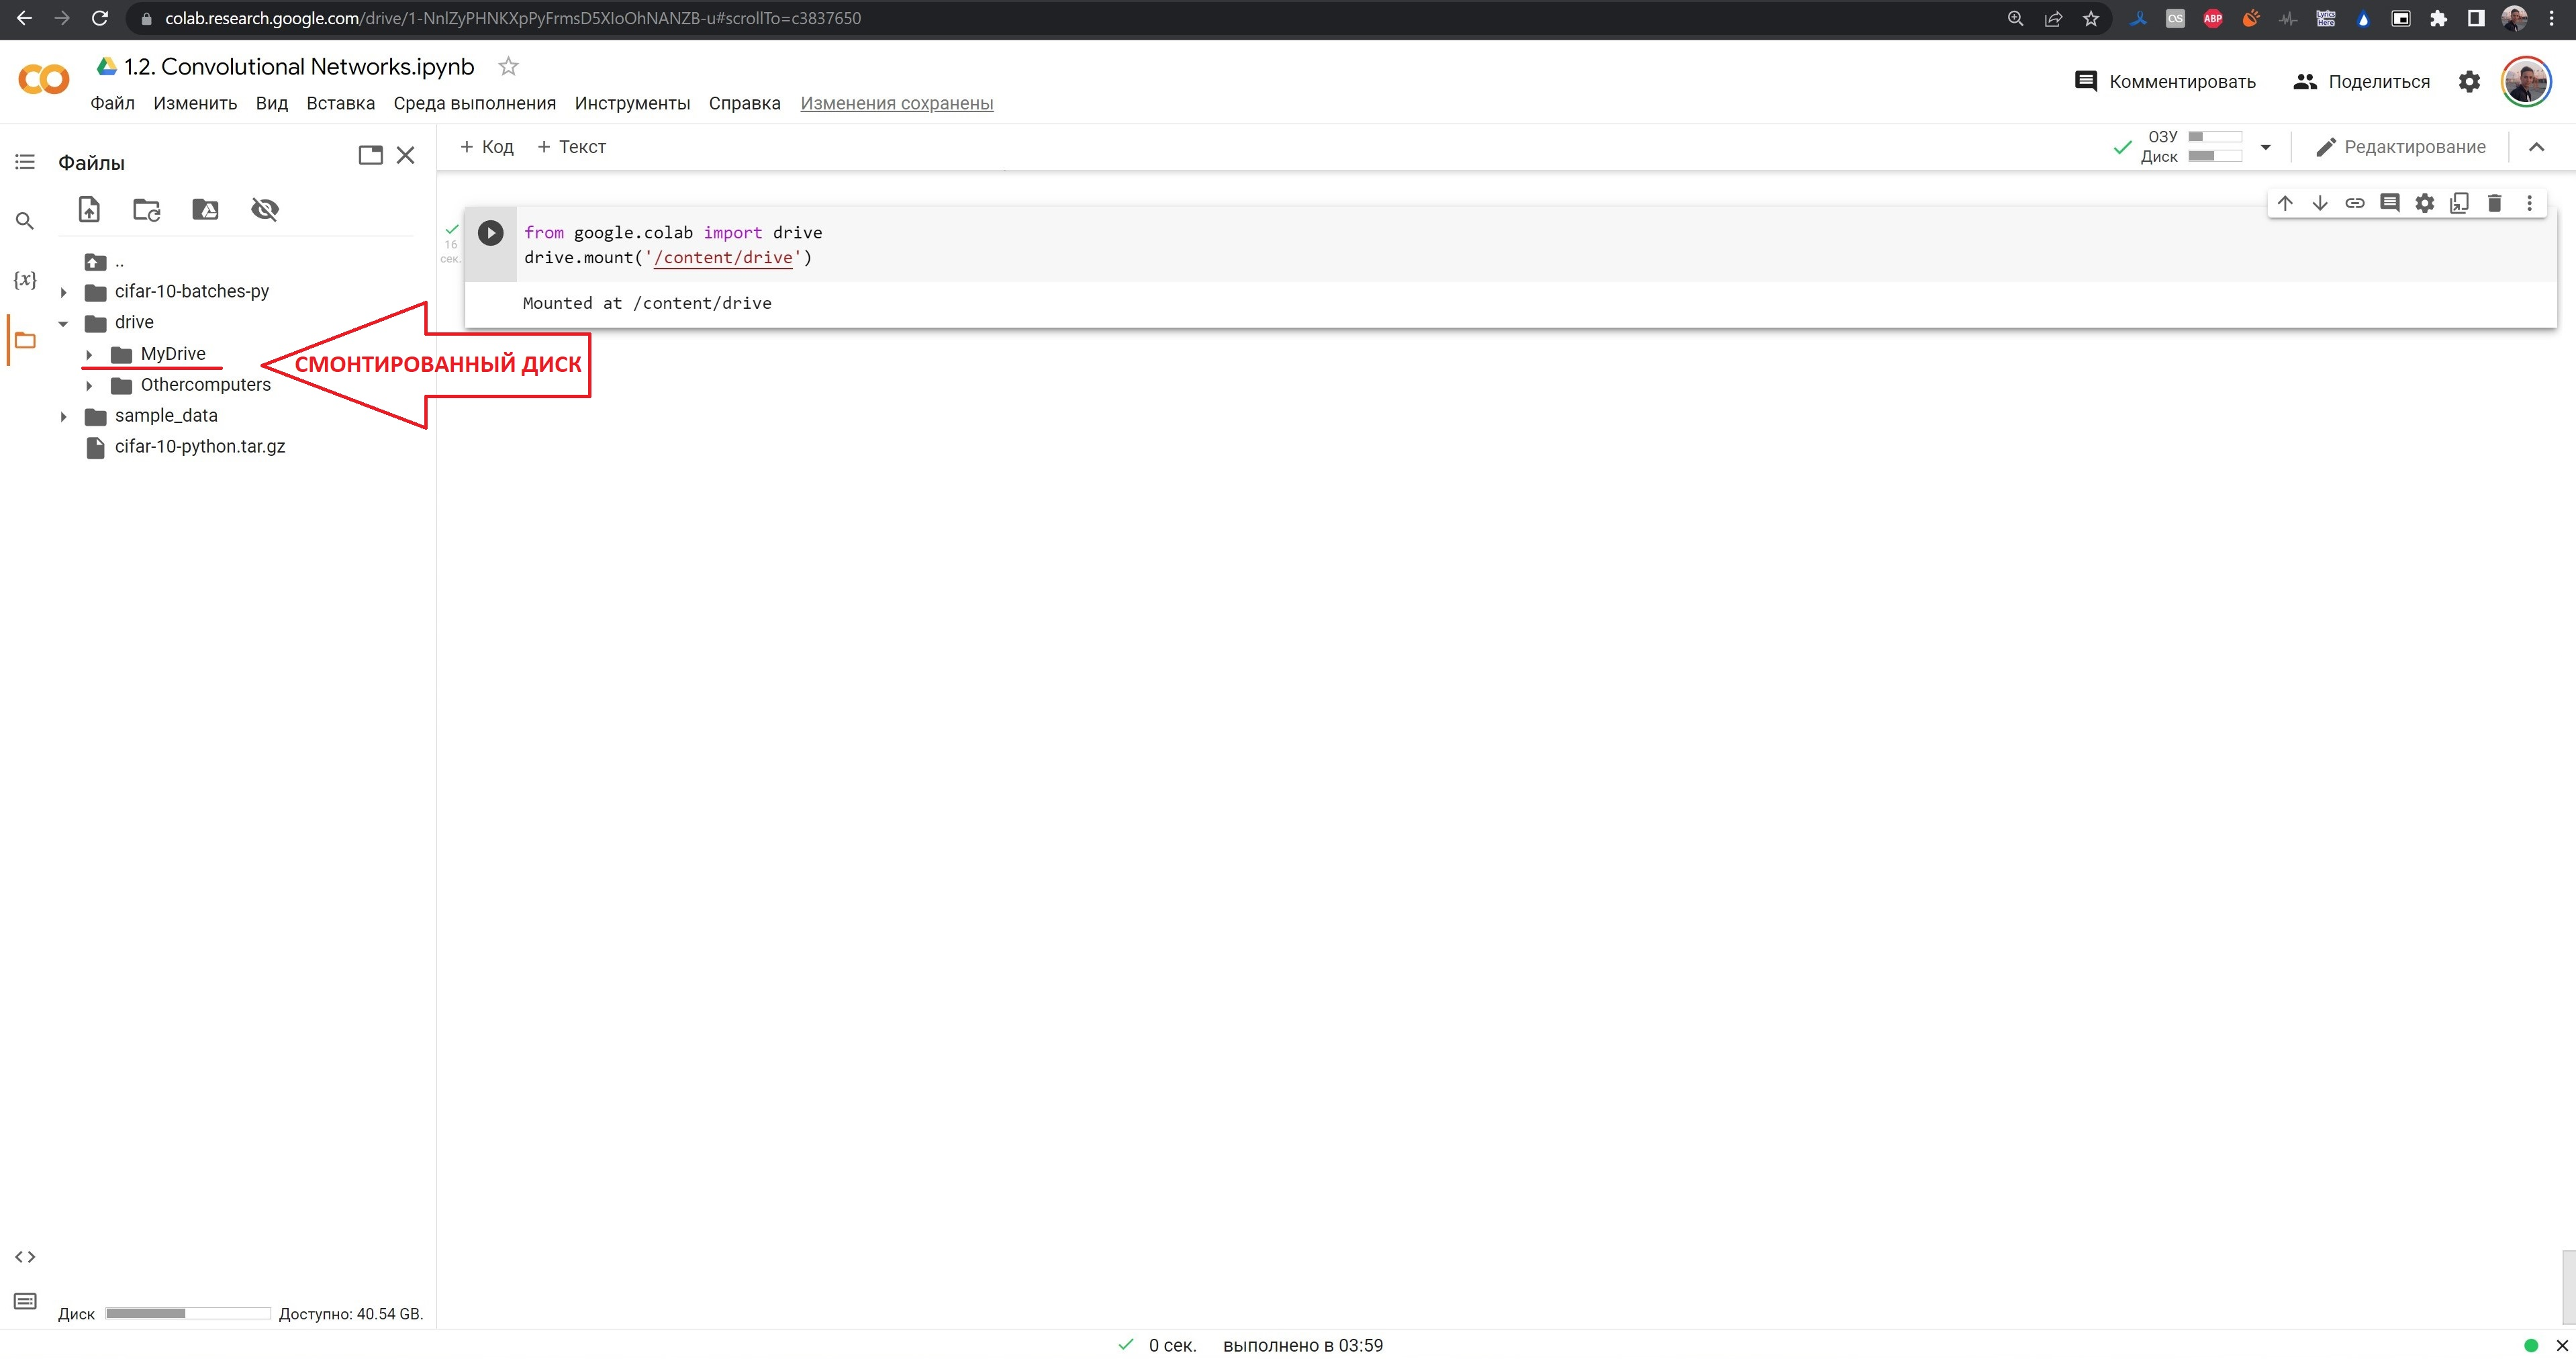

Теперь загрузим веса в "чистую" модель:

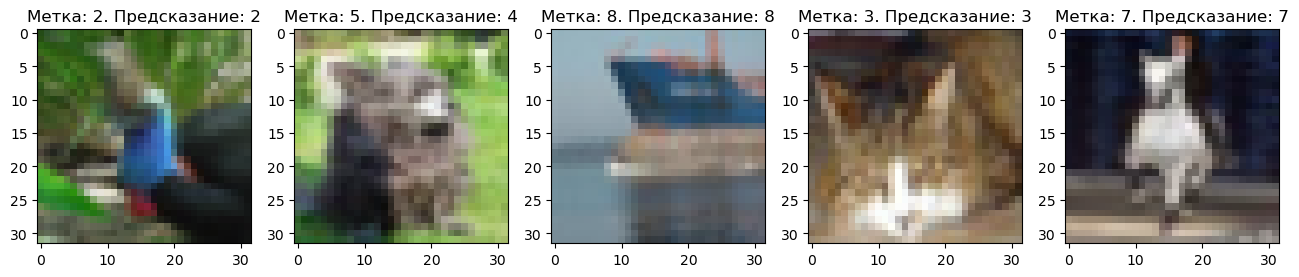

In [23]:
state_dict = torch.load('conv_weights.pt')

conv_network = ConvNet(use_batchnorm=True, dropout_p=0.5).to(device)
conv_network.load_state_dict(state_dict)

images, labels = next(iter(dl_test))

logits = conv_network(images.to(device))
predictions = torch.argmax(logits, dim=1).cpu()

fig, axes = plt.subplots(1, 5, figsize=(13, 4))
for idx, jdx in enumerate(np.random.randint(0, len(images), size=5)):
    axes[idx].imshow(inverse_transform(images[jdx]))
    axes[idx].set_title(f'Метка: {labels[jdx]}. Предсказание: {predictions[jdx]}')

fig.tight_layout()
plt.show()

Обратим внимание, что загрузка весов модели с помощью `torch.load` (а также с помощью любых других производных от [`pickle`](https://docs.python.org/3/library/pickle.html) функций) является [**небезопасной операцией**](https://pytorch.org/docs/stable/generated/torch.load.html#torch.load). 

Для примера, попробуем загрузить веса, модифицированные особым образом:

In [ ]:
torch.load('conv_weights_pretrained.pt')

<IPython.core.display.Javascript object>

{'features.0.weight': tensor([[[[ 0.0135, -0.1222, -0.0140],
           [-0.0583, -0.0326, -0.0327],
           [ 0.0364, -0.0228, -0.0144]],
 
          [[-0.1221,  0.0279, -0.0010],
           [ 0.1580,  0.0674, -0.1431],
           [-0.0802,  0.1627,  0.1680]],
 
          [[ 0.0060, -0.1505, -0.1332],
           [-0.1881,  0.0770,  0.1451],
           [ 0.1693,  0.1653, -0.0989]]],
 
 
         [[[-0.1572,  0.0840,  0.1532],
           [-0.1795,  0.1075,  0.0705],
           [ 0.0207, -0.1909,  0.0500]],
 
          [[-0.0900,  0.1825,  0.1370],
           [-0.0408, -0.1705, -0.0184],
           [ 0.1715,  0.0555, -0.0777]],
 
          [[-0.0672,  0.1577,  0.0703],
           [ 0.1888,  0.0674,  0.0603],
           [-0.1027, -0.1378,  0.0135]]],
 
 
         [[[-0.0790, -0.0692, -0.1516],
           [-0.1701,  0.1475,  0.0321],
           [-0.0049,  0.1399,  0.1633]],
 
          [[ 0.0734,  0.0740,  0.1897],
           [ 0.0612, -0.0136, -0.1917],
           [-0.0429,  0.0188, -0